In [2]:
# initial imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_auc_score, roc_curve, confusion_matrix, 
                           ConfusionMatrixDisplay)
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [26]:
import pandas as pd
import zipfile
import os

zip_path = r"C:\Users\Hp\Downloads\telco.zip" 

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("telco_data")

print("Zip file extracted successfully!")
csv_files = [f for f in os.listdir("telco_data") if f.endswith(".csv")]
print("CSV files found:", csv_files)

csv_path = os.path.join("telco_data", csv_files[0])
df = pd.read_csv(csv_path)
print(f"Dataset loaded: {df.shape}")

print("\nDATASET OVERVIEW:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

df.head(3)


Zip file extracted successfully!
CSV files found: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']
Dataset loaded: (7043, 21)

DATASET OVERVIEW:
Shape: (7043, 21)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [32]:
print("COMPREHENSIVE DATA QUALITY REPORT")
print("=" * 50)

print("1. DATASET BASIC INFO:")
print(f"   - Shape: {df.shape}")
print(f"   - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   - Duplicate rows: {df.duplicated().sum()}")

print("\n2. DATA TYPES AND MISSING VALUES:")
df_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df)) * 100,
    'Unique Values': df.nunique()
})
display(df_info)

print("\n3. BLANK STRINGS CHECK:")
blank_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':
        blank_count = (df[col].apply(lambda x: isinstance(x, str) and x.strip() == "")).sum()
        if blank_count > 0:
            blank_counts[col] = blank_count

if blank_counts:
    for col, count in blank_counts.items():
        print(f"   - {col}: {count} blank strings")
else:
    print("   - No blank strings found")

print(f"\n4. TOTALCHARGES SPECIFIC CHECK:")
print(f"   - Data type: {df['TotalCharges'].dtype}")
print(f"   - Sample values: {df['TotalCharges'].head(3).tolist()}")

COMPREHENSIVE DATA QUALITY REPORT
1. DATASET BASIC INFO:
   - Shape: (7043, 21)
   - Memory usage: 6.82 MB
   - Duplicate rows: 0

2. DATA TYPES AND MISSING VALUES:


,Data Type,Missing Values,Missing %,Unique Values
customerID,object,0,0.0,7043
gender,object,0,0.0,2
SeniorCitizen,int64,0,0.0,2
Partner,object,0,0.0,2
Dependents,object,0,0.0,2
tenure,int64,0,0.0,73
PhoneService,object,0,0.0,2
MultipleLines,object,0,0.0,3
InternetService,object,0,0.0,3
OnlineSecurity,object,0,0.0,3



3. BLANK STRINGS CHECK:
   - TotalCharges: 11 blank strings

4. TOTALCHARGES SPECIFIC CHECK:
   - Data type: object
   - Sample values: ['29.85', '1889.5', '108.15']


In [34]:
print("DATA CLEANING PROCESS")
print("=" * 40)

df_clean = df.copy()
print(f"Original shape: {df_clean.shape}")

print("\n1. CONVERTING TOTALCHARGES TO NUMERIC:")
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
missing_totalcharges = df_clean['TotalCharges'].isna().sum()
print(f"   - Rows with invalid TotalCharges: {missing_totalcharges}")

if missing_totalcharges > 0:
    print("   - Rows with missing TotalCharges:")
    display(df_clean[df_clean['TotalCharges'].isna()][['tenure', 'MonthlyCharges', 'TotalCharges']].head())

df_clean = df_clean.dropna(subset=['TotalCharges']).reset_index(drop=True)
print(f"   - After removal: {df_clean.shape}")

if 'customerID' in df_clean.columns:
    df_clean = df_clean.drop(columns=['customerID'])
    print("   - Dropped customerID column")

df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

print(f"\n2. FINAL CLEANED DATASET:")
print(f"   - Shape: {df_clean.shape}")
print(f"   - Columns: {list(df_clean.columns)}")

print("\n3. CLEANED DATASET INFO:")
df_clean_info = pd.DataFrame({
    'Data Type': df_clean.dtypes,
    'Missing Values': df_clean.isnull().sum(),
    'Unique Values': df_clean.nunique()
})
display(df_clean_info)
print("\nData cleaning completed successfully!")

DATA CLEANING PROCESS
Original shape: (7043, 21)

1. CONVERTING TOTALCHARGES TO NUMERIC:
   - Rows with invalid TotalCharges: 11
   - Rows with missing TotalCharges:


,tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN


   - After removal: (7032, 21)
   - Dropped customerID column

2. FINAL CLEANED DATASET:
   - Shape: (7032, 20)
   - Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

3. CLEANED DATASET INFO:


,Data Type,Missing Values,Unique Values
gender,object,0,2
SeniorCitizen,object,0,2
Partner,object,0,2
Dependents,object,0,2
tenure,int64,0,72
PhoneService,object,0,2
MultipleLines,object,0,3
InternetService,object,0,3
OnlineSecurity,object,0,3
OnlineBackup,object,0,3



Data cleaning completed successfully!


EXPLORATORY DATA ANALYSIS - TARGET VARIABLE


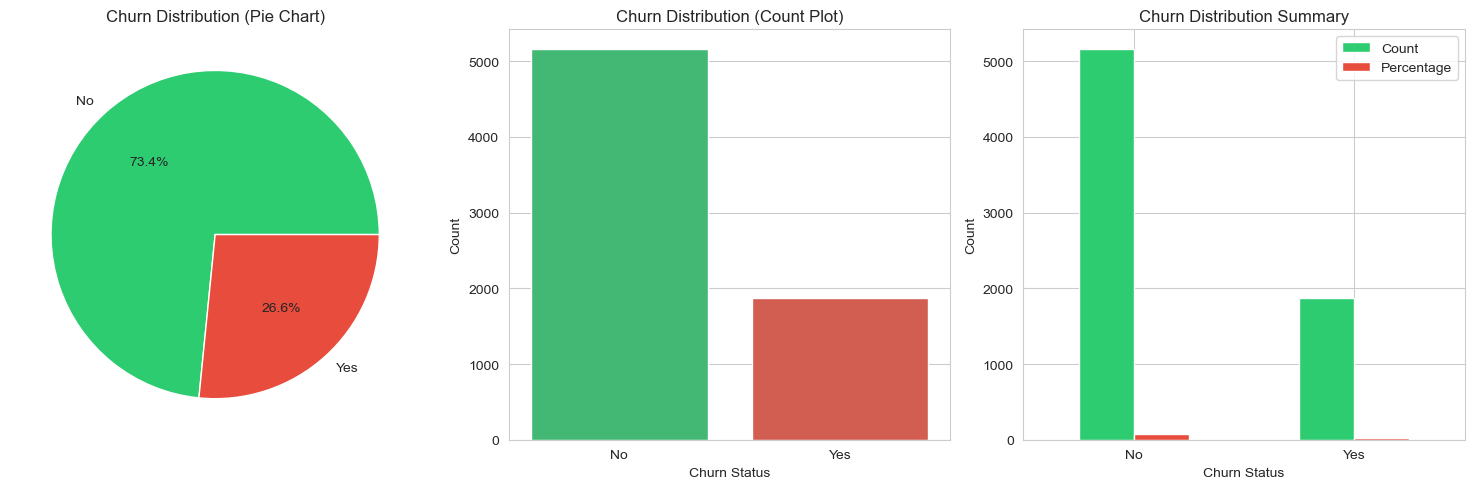


CHURN DISTRIBUTION SUMMARY:
       Count  Percentage
Churn                   
No      5163   73.421502
Yes     1869   26.578498


In [36]:
print("EXPLORATORY DATA ANALYSIS - TARGET VARIABLE")
print("=" * 50)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
churn_counts = df_clean['Churn'].value_counts()
churn_percentages = df_clean['Churn'].value_counts(normalize=True) * 100
colors = ['#2ecc71', '#e74c3c']  # Green for No, Red for Yes

plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Churn Distribution (Pie Chart)')

plt.subplot(1, 3, 2)
sns.countplot(data=df_clean, x='Churn', palette=colors)
plt.title('Churn Distribution (Count Plot)')
plt.xlabel('Churn Status')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
# summary table
churn_summary = pd.DataFrame({
    'Count': churn_counts,
    'Percentage': churn_percentages
})
churn_summary.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('Churn Distribution Summary')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("\nCHURN DISTRIBUTION SUMMARY:")
print(churn_summary)

NUMERICAL FEATURES ANALYSIS


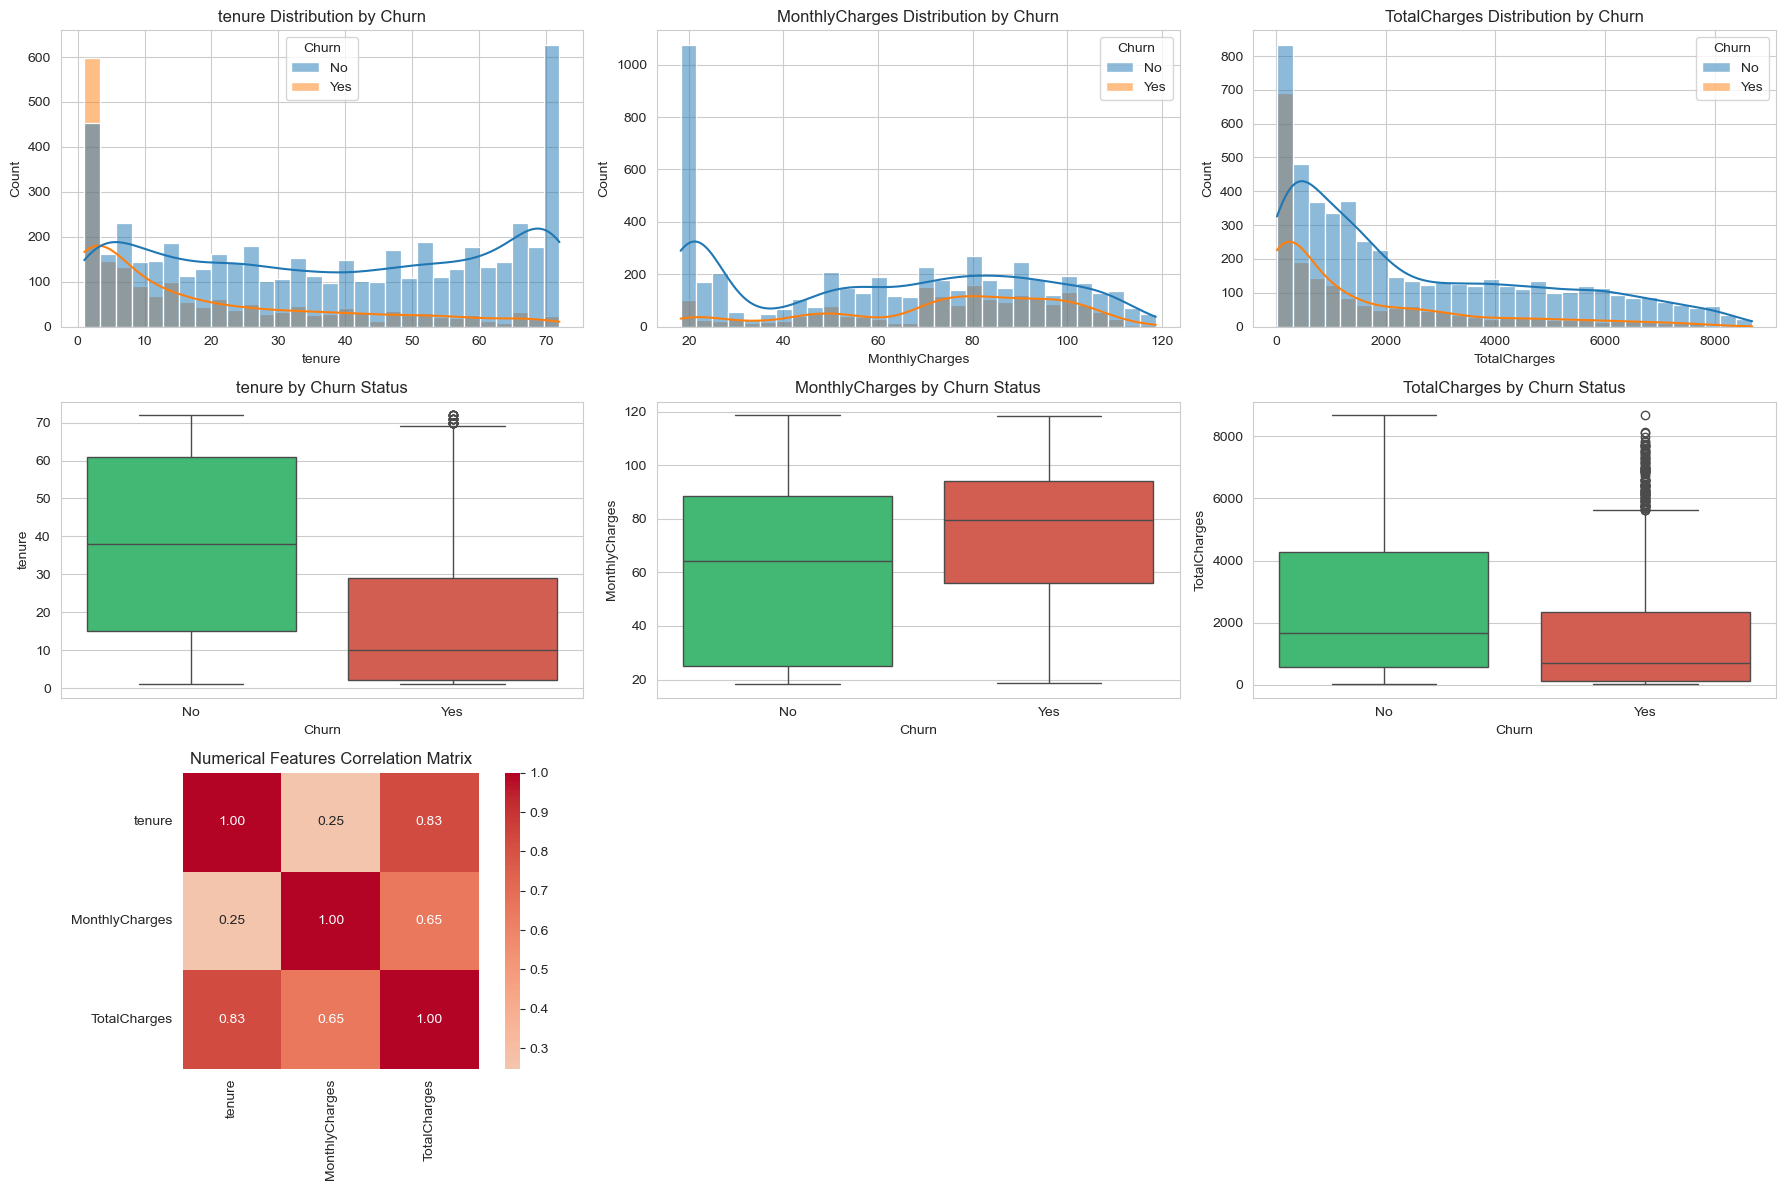


 NUMERICAL FEATURES STATISTICAL SUMMARY:


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000



 CORRELATION WITH CHURN (Point Biserial):
   - tenure: -0.354
   - MonthlyCharges: 0.193
   - TotalCharges: -0.199


In [38]:
print("NUMERICAL FEATURES ANALYSIS")
print("=" * 40)

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(18, 12))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f'{col} Distribution by Churn')
    plt.xlabel(col)
    
    plt.subplot(3, 3, i + 3)
    sns.boxplot(data=df_clean, x='Churn', y=col, palette=colors)
    plt.title(f'{col} by Churn Status')
    plt.xlabel('Churn')
    plt.ylabel(col)

plt.subplot(3, 3, 7)
correlation = df_clean[numerical_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Numerical Features Correlation Matrix')

plt.tight_layout()
plt.show()

print("\n NUMERICAL FEATURES STATISTICAL SUMMARY:")
display(df_clean[numerical_cols].describe())

print(f"\n CORRELATION WITH CHURN (Point Biserial):")
for col in numerical_cols:
    correlation = df_clean[col].corr(df_clean['Churn'].map({'Yes': 1, 'No': 0}))
    print(f"   - {col}: {correlation:.3f}")

CATEGORICAL FEATURES ANALYSIS


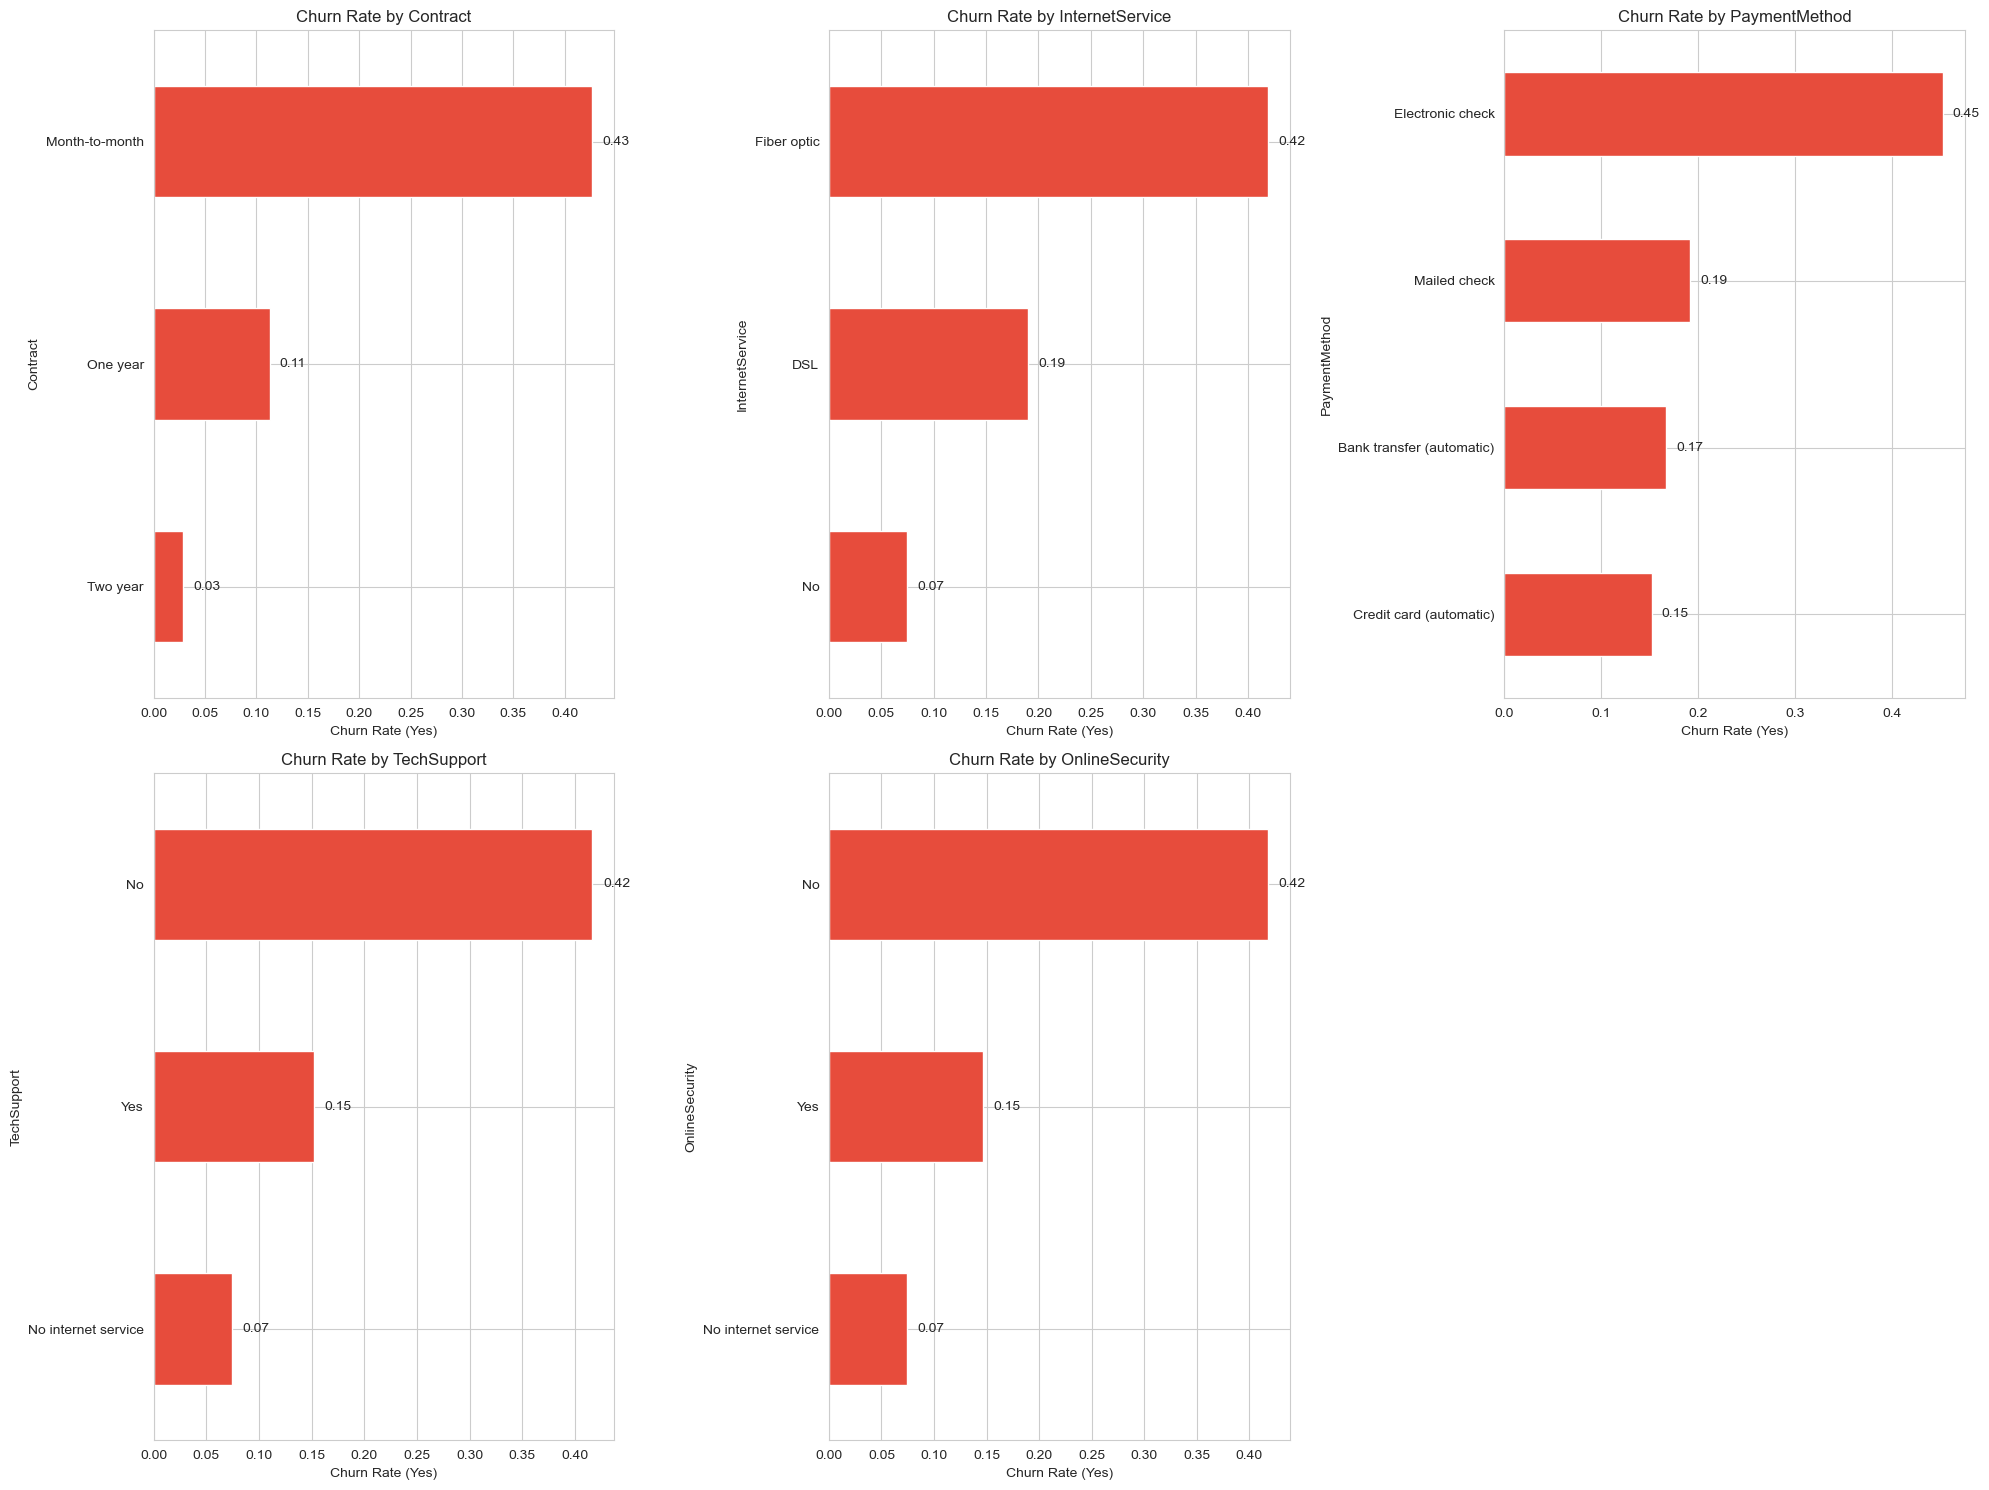

KEY INSIGHTS FROM CATEGORICAL FEATURES:
   - Contract: Highest churn in 'Month-to-month' (42.7%)
   - InternetService: Highest churn in 'Fiber optic' (41.9%)
   - PaymentMethod: Highest churn in 'Electronic check' (45.3%)
   - TechSupport: Highest churn in 'No' (41.6%)
   - OnlineSecurity: Highest churn in 'No' (41.8%)


In [40]:
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 45)

key_categorical = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport', 'OnlineSecurity']

plt.figure(figsize=(20, 15))

for i, col in enumerate(key_categorical, 1):
    plt.subplot(2, 3, i)
    
    churn_rate = df_clean.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    if churn_rate is not None and 'Yes' in churn_rate.columns:
        churn_rate['Yes'].sort_values(ascending=True).plot(kind='barh', color='#e74c3c')
        plt.title(f'Churn Rate by {col}')
        plt.xlabel('Churn Rate (Yes)')
        plt.ylabel(col)
        
        for j, (idx, val) in enumerate(churn_rate['Yes'].sort_values().items()):
            plt.text(val + 0.01, j, f'{val:.2f}', va='center')

plt.tight_layout()
plt.show()

print("KEY INSIGHTS FROM CATEGORICAL FEATURES:")
for col in key_categorical:
    churn_rates = df_clean.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
    highest_churn = churn_rates.index[0]
    highest_rate = churn_rates.iloc[0]
    print(f"   - {col}: Highest churn in '{highest_churn}' ({highest_rate:.1%})")

In [ ]:
print("FEATURE ENGINEERING & PREPROCESSING")
print("=" * 45)

df_model = df_clean.copy()

df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})
print(f"Target variable encoded: 1=Yes, 0=No")

X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 FEATURE TYPES:")
print(f"   - Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"   - Categorical features ({len(categorical_features)}): {categorical_features}")

# Display unique values in categorical features
print(f"\n🔍 CATEGORICAL FEATURES UNIQUE VALUES:")
for feature in categorical_features[:5]:  # Show first 5 to avoid clutter
    unique_vals = X[feature].unique()
    print(f"   - {feature}: {list(unique_vals)}")